# TikTok Usage Analysis Notebook
This notebook scrapes the Sabancı University academic calendar for holidays, enriches TikTok watch history with day-of-week and time bins, and performs EDA.

## 1. Scrape Holidays from Academic Calendar

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# 1. Map Turkish → English month abbreviations
month_map = {
    'Oca': 'Jan', 'Şub': 'Feb', 'Mar': 'Mar', 'Nis': 'Apr',
    'May': 'May', 'Haz': 'Jun', 'Tem': 'Jul', 'Ağu': 'Aug',
    'Eyl': 'Sep', 'Eki': 'Oct', 'Kas': 'Nov', 'Ara': 'Dec'
}
dash_re = re.compile(r'\s*[\u2013\u2014-]\s*')  # matches hyphen, en‐dash, em‐dash

def replace_months(text):
    for tr, en in month_map.items():
        text = re.sub(rf'\b{tr}\b', en, text)
    return text

def parse_range(range_str):
    txt = range_str.strip()
    # Multi‐day range?
    if dash_re.search(txt):
        start_raw, end_raw = dash_re.split(txt, maxsplit=1)
        # Normalize Turkish month names
        start_norm = replace_months(start_raw)
        end_norm   = replace_months(end_raw)
        # If start lacks year, borrow from end
        if not re.search(r'\d{4}', start_norm):
            m = re.search(r'([A-Za-z]+)\s+(\d{4})', end_norm)
            if m:
                month, year = m.groups()
                start_norm = f"{start_norm} {month} {year}"
        # Parse and expand
        start_dt = pd.to_datetime(start_norm, dayfirst=True)
        end_dt   = pd.to_datetime(end_norm,   dayfirst=True)
        return pd.date_range(start_dt, end_dt).date.tolist()
    else:
        # Single‐day entry
        norm = replace_months(txt)
        dt   = pd.to_datetime(norm, dayfirst=True)
        return [dt.date()]

# 2. Fetch & parse
url  = 'https://apps.sabanciuniv.edu/custom/academic-calendar/?a=0&b=2024&c=14&d=tr&e=0'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, 'html.parser')

# 3. Extract all “tatil” rows
holidays = []
for row in soup.select('tr'):
    tds = row.find_all('td', class_='yeniIcerik')
    if not tds:
        continue
    title = tds[0].get_text(strip=True).lower()
    if 'tatil' in title:
        for td in tds[1:]:
            span = td.find('span')
            txt  = span.get_text(strip=True) if span else ''
            if txt:
                holidays.extend(parse_range(txt))

# 4. Dedupe & sort
holiday_df = pd.DataFrame({'date': sorted(set(holidays))})
display(holiday_df)


,date


## 2. Load and Prepare TikTok Data

In [4]:
import json
import pandas as pd

# 1. Load the raw JSON
with open('/content/user_data_tiktok.json', 'r') as f:
    raw = json.load(f)

# 2. Drill down into “Your Activity” and find which sub‐dict has a list
activity = raw.get("Your Activity", {})
for section, content in activity.items():
    if isinstance(content, dict):
        for key, value in content.items():
            if isinstance(value, list):
                print(f"Found list at Your Activity → {section} → {key}")
# e.g. “Found list at Your Activity → Login History → LoginHistoryList”

# 3. Pick the one you want (here LoginHistoryList)
data_list = activity["Login History"]["LoginHistoryList"]

# 4. Normalize into DataFrame
df = pd.json_normalize(data_list)

# 5. Parse the “Date” column to a true datetime
df['timestamp'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# 6. Feature engineering exactly as before
df['day_of_week'] = df['timestamp'].dt.day_name()

def time_bin(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['time_bin'] = df['timestamp'].dt.hour.apply(time_bin)

# 7. Flag holidays (using your holiday_df)
df['date']       = df['timestamp'].dt.date
df['is_holiday'] = df['date'].isin(holiday_df['date'])

# 8. Preview
display(df.head())


Found list at Your Activity → Login History → LoginHistoryList
Found list at Your Activity → Searches → SearchList
Found list at Your Activity → Share History → ShareHistoryList
Found list at Your Activity → Status → Status List
Found list at Your Activity → Watch History → VideoList


,Date,IP,DeviceModel,DeviceSystem,NetworkType,Carrier,timestamp,day_of_week,time_bin,date,is_holiday
0,2024-10-20 03:20:12,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:12,Sunday,Night,2024-10-20,False
1,2024-10-20 03:20:26,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:26,Sunday,Night,2024-10-20,False
2,2024-10-20 03:27:40,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:27:40,Sunday,Night,2024-10-20,False
3,2024-10-20 06:59:39,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 06:59:39,Sunday,Morning,2024-10-20,False
4,2024-10-20 07:15:36,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 07:15:36,Sunday,Morning,2024-10-20,False


## 3. Exploratory Data Analysis (EDA)

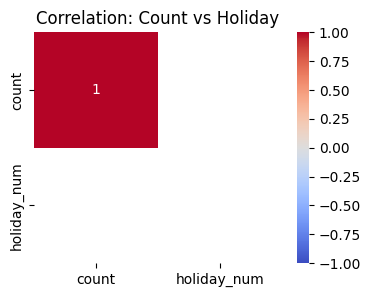

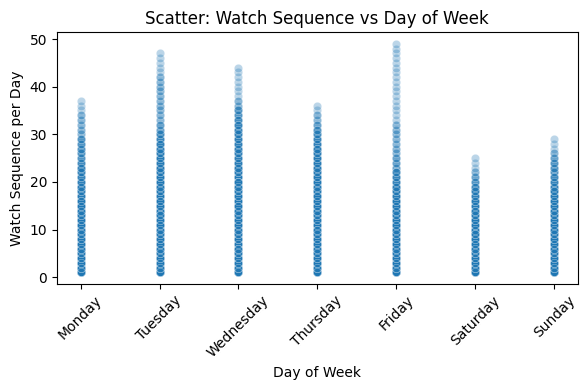

<ipython-input-6-7715c1fcc332>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_holiday', y='count', data=daily, palette=['#4E79A7','#F28E2B'])
<ipython-input-6-7715c1fcc332>:39: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(x='is_holiday', y='count', data=daily, palette=['#4E79A7','#F28E2B'])


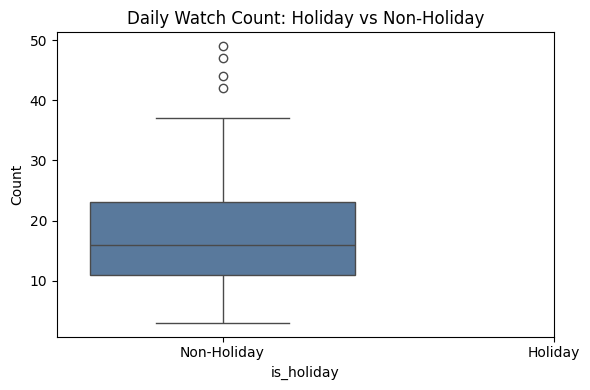

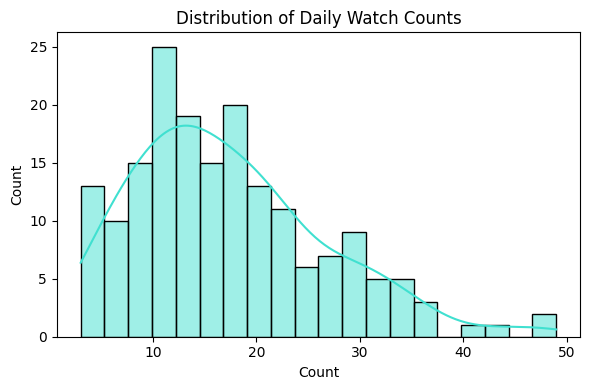

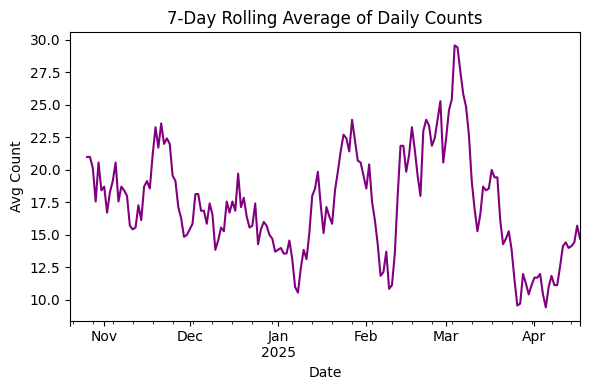

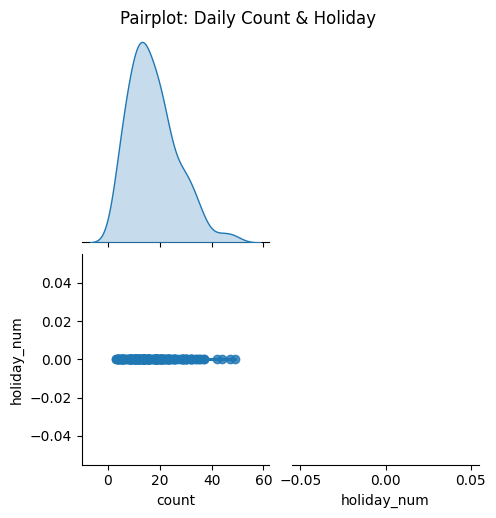

T-test: t = nan, p = nan
→ No significant difference in daily counts


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
<ipython-input-6-7715c1fcc332>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_holiday', y='hour', data=df, palette=['skyblue','salmon'])
<ipython-input-6-7715c1fcc332>:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(x='is_holiday', y='hour', data=df, palette=['skyblue','salmon'])


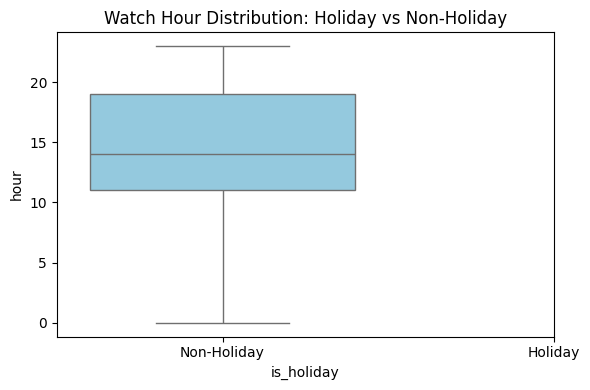

/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


Hour T-test: t = nan, p = nan


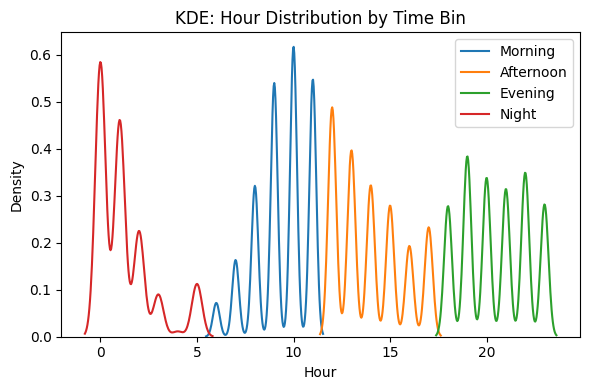

<ipython-input-6-7715c1fcc332>:105: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('timestamp').resample('M').size()


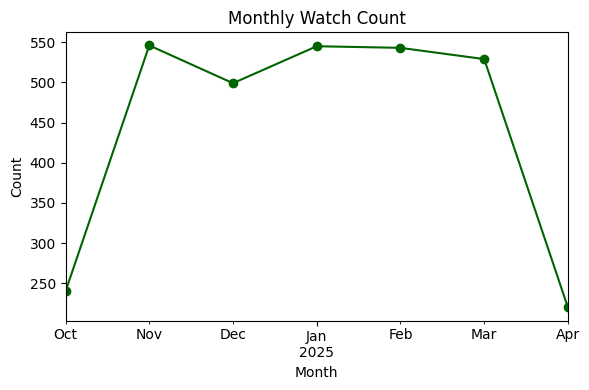

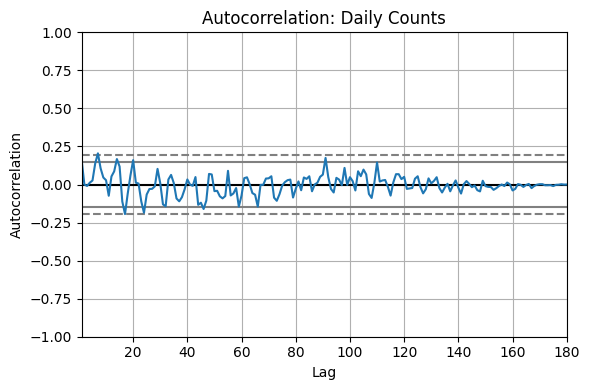

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# Assume df, holiday_df already defined, and df has 'timestamp', 'day_of_week', 'time_bin', 'is_holiday'

# 1) Compute daily watch counts and merge holiday flag
daily = df.groupby(df['timestamp'].dt.date).size().reset_index(name='count')
daily['date'] = pd.to_datetime(daily['timestamp'].astype(str))
daily['is_holiday'] = daily['date'].dt.date.isin(holiday_df['date'])

# 2) Correlation analysis on daily counts
# encode is_holiday as numeric
daily['holiday_num'] = daily['is_holiday'].astype(int)
corr = daily[['count','holiday_num']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Count vs Holiday')
plt.show()

# 3) Scatter plot: count vs. day of week (numeric)
# map day_of_week to ordered integer
dow_map = {d:i for i,d in enumerate(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])}
df['dow_num'] = df['day_of_week'].map(dow_map)
plt.figure(figsize=(6,4))
sns.scatterplot(x='dow_num', y=df.groupby(df['timestamp'].dt.date).cumcount()+1,
                data=df.reset_index(), alpha=0.3)
plt.xticks(range(7), dow_map.keys(), rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Watch Sequence per Day')
plt.title('Scatter: Watch Sequence vs Day of Week')
plt.tight_layout()
plt.show()

# 4) Boxplot: daily watch counts by holiday vs non-holiday
plt.figure(figsize=(6,4))
sns.boxplot(x='is_holiday', y='count', data=daily, palette=['#4E79A7','#F28E2B'])
plt.xticks([0,1], ['Non-Holiday','Holiday'])
plt.title('Daily Watch Count: Holiday vs Non-Holiday')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 5) Histogram: distribution of daily counts
plt.figure(figsize=(6,4))
sns.histplot(daily['count'], bins=20, kde=True, color='turquoise')
plt.title('Distribution of Daily Watch Counts')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# 6) Line plot: 7-day rolling average
rolling7 = daily.set_index('date')['count'].rolling(7).mean()
plt.figure(figsize=(6,4))
rolling7.plot(color='purple')
plt.title('7-Day Rolling Average of Daily Counts')
plt.xlabel('Date')
plt.ylabel('Avg Count')
plt.tight_layout()
plt.show()

# 7) Pairplot of numeric features
sns.pairplot(daily[['count','holiday_num']], kind='reg', diag_kind='kde', corner=True)
plt.suptitle('Pairplot: Daily Count & Holiday', y=1.02)
plt.show()

# 8) Hypothesis test: T-test for difference in daily counts
holiday_counts = daily.loc[daily['is_holiday'], 'count']
nonholiday_counts = daily.loc[~daily['is_holiday'], 'count']
t_stat, p_val = stats.ttest_ind(holiday_counts, nonholiday_counts, equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("→ Significant difference in daily counts (α=0.05)")
else:
    print("→ No significant difference in daily counts")

# 9) Boxplot & hypothesis test: watch hour by holiday
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(6,4))
sns.boxplot(x='is_holiday', y='hour', data=df, palette=['skyblue','salmon'])
plt.xticks([0,1], ['Non-Holiday','Holiday'])
plt.title('Watch Hour Distribution: Holiday vs Non-Holiday')
plt.tight_layout()
plt.show()

h_h = df.loc[df['is_holiday'], 'hour']
nh_h = df.loc[~df['is_holiday'], 'hour']
t2, p2 = stats.ttest_ind(h_h, nh_h, equal_var=False)
print(f"Hour T-test: t = {t2:.2f}, p = {p2:.4f}")

# 10) KDE plots: time_bin distributions
plt.figure(figsize=(6,4))
for tb in ['Morning','Afternoon','Evening','Night']:
    subset = df[df['time_bin']==tb]['timestamp'].dt.hour
    sns.kdeplot(subset, label=tb, bw_adjust=0.5)
plt.title('KDE: Hour Distribution by Time Bin')
plt.xlabel('Hour')
plt.legend()
plt.tight_layout()
plt.show()

# 11) Seasonality: monthly total counts
monthly = df.set_index('timestamp').resample('M').size()
plt.figure(figsize=(6,4))
monthly.plot(marker='o', color='darkgreen')
plt.title('Monthly Watch Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 12) Autocorrelation plot
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(6,4))
autocorrelation_plot(daily.set_index('date')['count'])
plt.title('Autocorrelation: Daily Counts')
plt.tight_layout()
plt.show()

# 13) Session duration analysis (if session_df defined)
# session_df['duration_min'] exists from session grouping earlier
if 'session_df' in globals():
    plt.figure(figsize=(6,4))
    sns.histplot(session_df['duration_min'], bins=30, kde=True, color='orchid')
    plt.title('Distribution of Session Durations (min)')
    plt.xlabel('Duration (min)')
    plt.tight_layout()
    plt.show()

    # corr between duration and start hour
    sess = session_df.copy()
    sess['start_hour'] = sess['min'].dt.hour
    corr2 = sess[['duration_min','start_hour']].corr()
    plt.figure(figsize=(4,3))
    sns.heatmap(corr2, annot=True, cmap='coolwarm')
    plt.title('Corr: Duration vs Start Hour')
    plt.tight_layout()
    plt.show()

    # scatter
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='start_hour', y='duration_min', data=sess, alpha=0.6)
    plt.title('Session Duration vs Start Hour')
    plt.xlabel('Start Hour')
    plt.ylabel('Duration (min)')
    plt.tight_layout()
    plt.show()

# 14) Pairplot including session duration if available
if 'session_df' in globals():
    sess_plot = sess[['duration_min','start_hour']]
    sns.pairplot(sess_plot, kind='reg', diag_kind='kde', corner=True)
    plt.suptitle('Pairplot: Session Dur & Start Hour', y=1.02)
    plt.show()


In [14]:
# === Cell 3 (updated): Classification – Predict time_bin ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import OneHotEncoder
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import classification_report
import numpy as np

# Features & target
X = df[['day_of_week','is_holiday','NetworkType','DeviceModel']]
y = df['time_bin']

# One-hot encoding (sklearn ≥1.2 uses sparse_output instead of sparse)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_enc = ohe.fit_transform(X)

# Train/test split (stratify to preserve class balance)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr, y_tr)

# Evaluate
y_pred = clf.predict(X_te)
print("Classification Report for time_bin:")
print(classification_report(y_te, y_pred))


Classification Report for time_bin:
              precision    recall  f1-score   support

   Afternoon       0.39      0.41      0.40       222
     Evening       0.40      0.60      0.48       213
     Morning       0.42      0.16      0.24       164
       Night       0.25      0.04      0.07        26

    accuracy                           0.40       625
   macro avg       0.36      0.30      0.30       625
weighted avg       0.39      0.40      0.37       625



=== Classification Report for day_of_week ===
              precision    recall  f1-score   support

      Friday       0.41      0.17      0.24        84
      Monday       0.17      0.15      0.16        85
    Saturday       0.26      0.19      0.22        63
      Sunday       0.33      0.17      0.22        76
    Thursday       0.28      0.43      0.34       104
     Tuesday       0.25      0.33      0.29       107
   Wednesday       0.34      0.42      0.38       106

    accuracy                           0.28       625
   macro avg       0.29      0.27      0.26       625
weighted avg       0.29      0.28      0.27       625



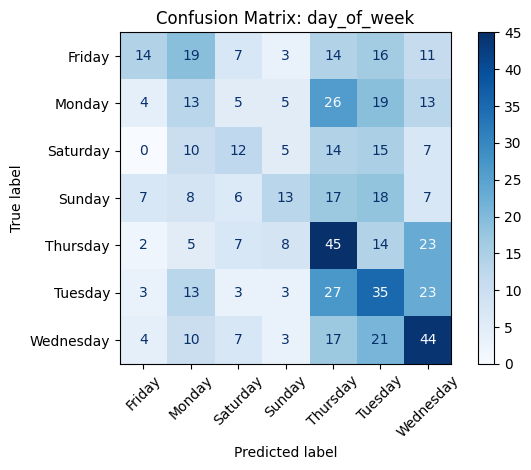

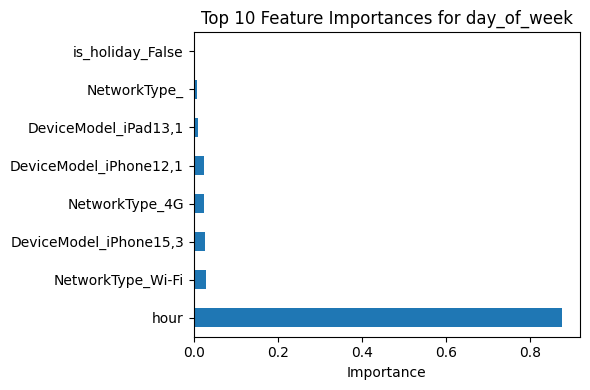

In [17]:
# === Cell 5: Classification – Predict day_of_week ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Define features & target
# Use hour, is_holiday, NetworkType, DeviceModel to predict day_of_week
X = df[['hour', 'is_holiday', 'NetworkType', 'DeviceModel']]
y = df['day_of_week']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Preprocessing pipeline
numeric_features = ['hour']
numeric_transformer = StandardScaler()

categorical_features = ['is_holiday', 'NetworkType', 'DeviceModel']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4) Full pipeline with Random Forest
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# 5) Fit model
clf_pipeline.fit(X_train, y_train)

# 6) Predict & evaluate
y_pred = clf_pipeline.predict(X_test)
print("=== Classification Report for day_of_week ===")
print(classification_report(y_test, y_pred))

# 7) Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf_pipeline, X_test, y_test,
    display_labels=clf_pipeline.named_steps['classifier'].classes_,
    cmap='Blues', xticks_rotation=45
)
plt.title('Confusion Matrix: day_of_week')
plt.tight_layout()
plt.show()

# 8) Feature importances
# Extract one-hot feature names
ohe = clf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_cols = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_cols)
importances = clf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 9) Plot top 10 feature importances
plt.figure(figsize=(6,4))
feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances for day_of_week')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
